In [75]:
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# add the top level directory to allow it to be imported
import sys
sys.path.append(os.path.split(os.getcwd())[0])
from utilities import plotting_utilities
from utilities import helper_functions

In [2]:
data_path = os.path.join(os.path.split(os.getcwd())[0],'data')
session_list = pd.read_csv(os.path.join(os.path.join(data_path,'session_list.csv')))
anesthesia_sessions = session_list.query('session_type == "anesthesia"')
anesthesia_sessions

,mouse_id,sex,genotype,AP_coord,ML_coord,DV_coord,session_type,recording_date,processing_date
0,M334412,M,Gnb4-IRES2-Cre;AAV-GCaMP6s,1.5,2.625,2.7,anesthesia,0,2019-03-14 17:37:57.629808903-07:00
1,M348126,F,Gnb4-IRES2-CreERT2/wt;Camk2a-tTA/wt;Ai94(TITL-...,1.5,2.625,2.5,anesthesia,0,2019-03-14 19:28:13.741096020-07:00
2,M339255,F,Gnb4-IRES2-Cre;AAV-GCaMP6s,1.5,2.625,2.7,anesthesia,0,2019-03-14 23:05:12.098660707-07:00
3,M334410,M,Gnb4-IRES2-Cre;AAV-GCaMP6s,1.5,2.625,2.5,anesthesia,0,2019-03-15 02:11:08.873144865-07:00
4,M335379,M,Gnb4-IRES2-CreERT2/wt;Camk2a-tTA/wt;Ai94(TITL-...,1.5,3.125,2.5,anesthesia,0,2019-03-15 05:08:14.018605709-07:00
5,M375765,M,Gnb4-IRES2-CreERT2/wt;Camk2a-tTA/wt;Ai93(TITL-...,1.5,2.625,2.5,anesthesia,0,2019-03-15 07:12:19.855928898-07:00
6,M397408,F,Gnb4-IRES2-CreERT2/wt;Camk2a-tTA/wt;Ai93(TITL-...,1.5,2.625,2.5,anesthesia,0,2019-03-13 20:32:17.976514578-07:00
7,M416531,F,Gnb4-IRES2-CreERT2/wt;Camk2a-tTA/wt;Ai93(TITL-...,1.5,3.125,2.5,anesthesia,0,2019-03-25 16:23:02.121844530-07:00


In [24]:
session = {}
pre_anesthesia_frames_df = pd.read_csv(os.path.join(data_path,'anesthesia_sessions','pre_anesthesia_frames.csv'))
for idx,row in anesthesia_sessions.iterrows():
    print('on session {} of {}'.format(idx+1,len(anesthesia_sessions)), end = '\r')
    mouse_id = row['mouse_id']
    session[mouse_id] = helper_functions.load_session(row['mouse_id'], session_type='anesthesia')
    
    pre_anesthesia_frames = pre_anesthesia_frames_df.query('mouse_id == @mouse_id')['pre_anesthesia_frames'].values[0]
    time = session[mouse_id].filtered_traces['t']
    session[mouse_id].filtered_traces['t_relative'] = time - time[pre_anesthesia_frames]


In [27]:
all_dfs = []
for mouse_id in session.keys():
    
    all_dfs.append(session[mouse_id].filtered_traces.rename(columns={C:'{}_{}'.format(C,mouse_id,) for C in session[mouse_id].filtered_traces if C.startswith('C')}))
    # note: by scaling, rounding, then casting to int, I'm ensuring that the 't_relative_scaled' column can be used
    #       as the merge-on column below without issues due to decimal resolution
    all_dfs[-1]['t_relative_scaled'] = all_dfs[-1]['t_relative'].map(lambda x:int(round(x*100)))

In [55]:
traces_merged = all_dfs[0].copy().drop(columns=['t', 't_relative'])
for i in range(1,len(all_dfs)):
    traces_merged = traces_merged.merge(
        all_dfs[i].drop(columns=['t', 't_relative']),
        on='t_relative_scaled',
        how='outer'
    ).sort_values(by='t_relative_scaled')

# rescale time (multiplied by 100 above to avoid decimal precision issues)
traces_merged['t_relative'] = traces_merged['t_relative_scaled'].map(lambda x:x/100)

1
2
3
4
5
6
7


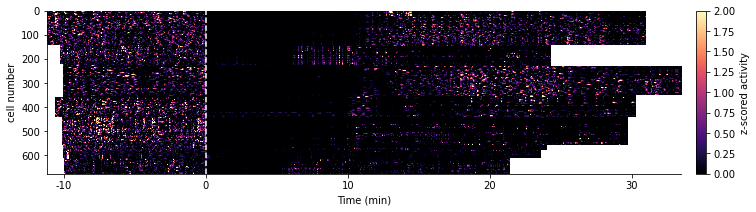

In [81]:
def plot_combined_heatmap(ax=None):
    if ax is None:
        fig,ax=plt.subplots(figsize=(12,3))
    helper_functions.heat_plot(traces_merged, ax=ax, clim=[0,2], time_label='t_relative')
    ax.axvline(0,color='white',linestyle='dashed')
    ax.set_xticks([-600,0,600,1200,1800]);
    ax.set_xticklabels([-10,0,10,20,30])
    ax.set_xlabel('Time (min)');
    ax.set_ylabel('cell number');
    sns.despine()
    
plot_combined_heatmap()

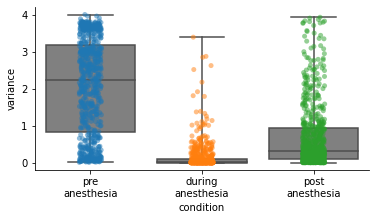

In [93]:
def plot_variance(ax=None):
    cell_ids = [c for c in traces_merged.columns if c.startswith('C')]

    # build a dataframe of pre-anesthesia values
    df_pre = pd.DataFrame(traces_merged.query('t_relative<0')[cell_ids].var(axis=0))
    df_pre = df_pre.rename(columns={0:'variance'})
    df_pre['condition'] = 'pre_variance'

    # build a dataframe of anesthesia values - first 10 minutes of post-anesthesia recording
    df_iso = pd.DataFrame(traces_merged.query('t_relative>0 and t_relative < 600')[cell_ids].var(axis=0))
    df_iso  = df_iso.rename(columns={0:'variance'})
    df_iso ['condition'] = 'iso_variance'

    # build a dataframe of post-anesthesia values - last 10 minutes of post-anesthesia recording
    df_post = []
    for cell in cell_ids:
        final_time = traces_merged['t_relative'][pd.notnull(traces_merged[cell])].max()
        v = traces_merged[[cell,'t_relative']].query('t_relative>(@final_time-600) and t_relative<@final_time')
        df_post.append({
            'cell_id':cell,
            'variance':v[cell].var(),
            'condition':'post_variance'
        })
    df_post = pd.DataFrame(df_post).set_index('cell_id')

    df_all = pd.concat([df_pre,df_iso,df_post])

    if ax is None:
        fig,ax=plt.subplots(figsize=(6,3))
    sns.stripplot(
        x='condition',
        y='variance',
        data=df_all,
        ax=ax,
        alpha=0.5
    )
    sns.boxplot(
        x='condition',
        y='variance',
        data=df_all,
        ax=ax,
        whis=np.inf,
        palette = ['gray','gray','gray']
    )
    
    ax.set_xticklabels([
        'pre\nanesthesia',
        'during\nanesthesia',
        'post\nanesthesia'
    ])

    sns.despine()
    
plot_variance()

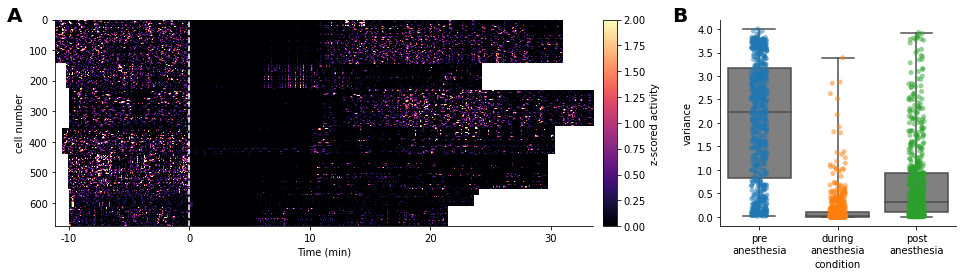

In [94]:
figsize=(2*8.5,2*2)
figure = plt.figure(figsize=figsize)
axes = {
    'A':plotting_utilities.placeAxesOnGrid(figure, xspan=[0.05,0.65], yspan=[0.05,1]),
    'B':plotting_utilities.placeAxesOnGrid(figure, xspan=[0.75,1], yspan=[0.05,1]),
}
    
plot_combined_heatmap(axes['A'])
plot_variance(axes['B'])

# add labels
labels = [
    {'label_text':'A', 'xpos':0,   'ypos':0.05},
    {'label_text':'B', 'xpos':0.7, 'ypos':0.05},
]
for label in labels:
    plotting_utilities.add_label(
        figure,
        label_text = label['label_text'],
        xpos = label['xpos'],
        ypos = label['ypos'],
        fontsize=20,
        weight="bold"
    )